In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import itertools

import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load the dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/stepthom/sandbox/master/data/OJ.csv")

In [3]:
df.head()
df.info()
df.dtypes

,ID,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 19 columns):
ID                1070 non-null int64
Purchase          1070 non-null object
WeekofPurchase    1070 non-null int64
StoreID           1070 non-null int64
PriceCH           1070 non-null float64
PriceMM           1070 non-null float64
DiscCH            1070 non-null float64
DiscMM            1070 non-null float64
SpecialCH         1070 non-null int64
SpecialMM         1070 non-null int64
LoyalCH           1070 non-null float64
SalePriceMM       1070 non-null float64
SalePriceCH       1070 non-null float64
PriceDiff         1070 non-null float64
Store7            1070 non-null object
PctDiscMM         1070 non-null float64
PctDiscCH         1070 non-null float64
ListPriceDiff     1070 non-null float64
STORE             1070 non-null int64
dtypes: float64(11), int64(6), object(2)
memory usage: 159.0+ KB


ID                  int64
Purchase           object
WeekofPurchase      int64
StoreID             int64
PriceCH           float64
PriceMM           float64
DiscCH            float64
DiscMM            float64
SpecialCH           int64
SpecialMM           int64
LoyalCH           float64
SalePriceMM       float64
SalePriceCH       float64
PriceDiff         float64
Store7             object
PctDiscMM         float64
PctDiscCH         float64
ListPriceDiff     float64
STORE               int64
dtype: object

In [4]:
import pandas_profiling
from pandas_profiling import ProfileReport

In [5]:
profile = ProfileReport(df, title='Pandas Profiling Report')
profile

We used profiling report to explore the data types and correlation. As per the above report we noticed we do not have any missing values in the loaded dataset. There are 3 highly correlated features " PctDiscMM','PctDiscCH','Store7" which we have removed, to avoid the bias on the classification model. 

Also we noticed that the target value ration : we have 62% Citrulls hiss product values, 48% Minute Maid. which indicates that data is somewhat balanced.

# Data cleaning, transformation
We changed categorical values to numeric or dummies. 
removed the values with high correlations

In [6]:
df.isnull().sum()
df['Purchase'] = df['Purchase'].replace(['CH','MM'],[1,0])
df['Store7'] = df['Store7'].replace(['Yes','No'],[1,0])
df = df.drop(['PctDiscMM','PctDiscCH','Store7'], axis=1)
df

ID                0
Purchase          0
WeekofPurchase    0
StoreID           0
PriceCH           0
PriceMM           0
DiscCH            0
DiscMM            0
SpecialCH         0
SpecialMM         0
LoyalCH           0
SalePriceMM       0
SalePriceCH       0
PriceDiff         0
Store7            0
PctDiscMM         0
PctDiscCH         0
ListPriceDiff     0
STORE             0
dtype: int64

,ID,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,ListPriceDiff,STORE
0,1,1,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,0.24,1
1,2,1,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,0.24,1
2,3,1,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,0.23,1
3,4,0,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,0.00,1
4,5,1,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,1066,1,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,0.23,0
1066,1067,1,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,0.32,0
1067,1068,0,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,0.32,0
1068,1069,1,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,0.27,0


In [7]:
df.dtypes
df.isnull().sum()

ID                  int64
Purchase            int64
WeekofPurchase      int64
StoreID             int64
PriceCH           float64
PriceMM           float64
DiscCH            float64
DiscMM            float64
SpecialCH           int64
SpecialMM           int64
LoyalCH           float64
SalePriceMM       float64
SalePriceCH       float64
PriceDiff         float64
ListPriceDiff     float64
STORE               int64
dtype: object

ID                0
Purchase          0
WeekofPurchase    0
StoreID           0
PriceCH           0
PriceMM           0
DiscCH            0
DiscMM            0
SpecialCH         0
SpecialMM         0
LoyalCH           0
SalePriceMM       0
SalePriceCH       0
PriceDiff         0
ListPriceDiff     0
STORE             0
dtype: int64

# Data Split
We are splitting the data here for X_train and Y_train. 

In [8]:
X = df.iloc[:,3:19]
Y = df['Purchase']

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Decision tree

Here we are building our first classification model using above splitted test and train dataset

In [10]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=10, min_samples_leaf=10, max_depth=3, max_leaf_nodes=5)
clf.fit(X_train, y_train)

y_pred_dt = clf.predict(X_test)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=5,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=42)

In [11]:
feature_names = X.columns
class_names = [str(x) for x in clf.classes_]
y_test

644    1
629    0
70     1
962    1
787    1
      ..
486    1
833    0
312    1
458    0
652    1
Name: Purchase, Length: 214, dtype: int64

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_dt)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_dt, target_names= class_names))


array([[75,  9],
       [43, 87]], dtype=int64)

              precision    recall  f1-score   support

           0       0.64      0.89      0.74        84
           1       0.91      0.67      0.77       130

    accuracy                           0.76       214
   macro avg       0.77      0.78      0.76       214
weighted avg       0.80      0.76      0.76       214



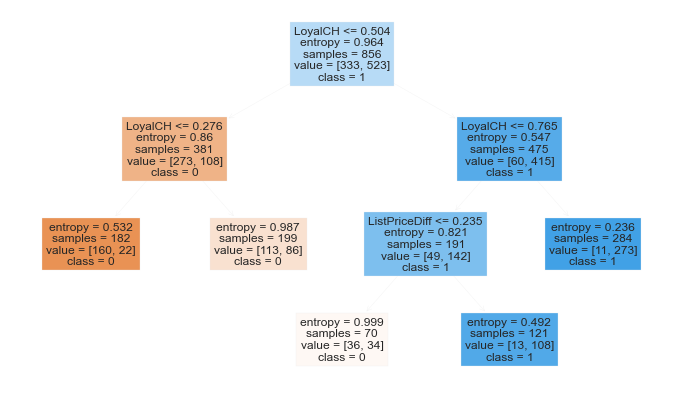

In [13]:
# Needs sklearn 0.21 or higher
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 7));
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names, proportion=False, fontsize=12);

# Random Forest Model
our second model Random forest
In this model, we used different hyper parameters.. We changed n_estimator values starting from 25, 50, 75 and 100.
Best prediction value we got in the model when we had n_estimator value at 50. 

In [14]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import model_selection

classifier = RandomForestClassifier(n_estimators =50, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train) 

# Prediction on Test Set #
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
con_mat = confusion_matrix(y_test, y_pred)

# Accuracy, Sensitivity, Specificity #
total3=sum(sum(con_mat))
accuracy3=(con_mat[0,0]+con_mat[1,1])/total3
print ('Accuracy : ', accuracy3)

sensitivity3 = con_mat[0,0]/(con_mat[0,0]+con_mat[0,1])
print('Sensitivity : ', sensitivity3 )

specificity3 = con_mat[1,1]/(con_mat[1,0]+con_mat[1,1])
print('Specificity : ', specificity3) 


RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=0)

Accuracy :  0.7429906542056075
Sensitivity :  0.6666666666666666
Specificity :  0.7923076923076923


In [15]:
#random forest
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names= class_names))

array([[ 56,  28],
       [ 27, 103]], dtype=int64)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        84
           1       0.79      0.79      0.79       130

    accuracy                           0.74       214
   macro avg       0.73      0.73      0.73       214
weighted avg       0.74      0.74      0.74       214



# XGboost
here as well fine tuned the model changing its n_estimator values to detemine the best prediction accuracy.

In [34]:
# XGBOOST #
from sklearn.ensemble import GradientBoostingClassifier
classifier6=GradientBoostingClassifier(n_estimators=85,random_state=0)
classifier6.fit(X_train,y_train)


# Prediction on Test Set #
y_pred4 = classifier6.predict(X_test)


# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm4 = confusion_matrix(y_test, y_pred4)


# Accuracy, Sensitivity, Specificity #
total4=sum(sum(cm4))
accuracy4=(cm4[0,0]+cm4[1,1])/total4
print ('Accuracy : ', accuracy4)

sensitivity4 = cm4[0,0]/(cm4[0,0]+cm4[0,1])
print('Sensitivity : ', sensitivity4 )

specificity4 = cm4[1,1]/(cm4[1,0]+cm4[1,1])
print('Specificity : ', specificity4) 


GradientBoostingClassifier(n_estimators=85, random_state=0)

Accuracy :  0.7990654205607477
Sensitivity :  0.7142857142857143
Specificity :  0.8538461538461538


In [32]:
#XGBOOST
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred4)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred4, target_names= class_names))

array([[ 58,  26],
       [ 16, 114]], dtype=int64)

              precision    recall  f1-score   support

           0       0.78      0.69      0.73        84
           1       0.81      0.88      0.84       130

    accuracy                           0.80       214
   macro avg       0.80      0.78      0.79       214
weighted avg       0.80      0.80      0.80       214

